In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import tensorflow.keras.backend as K

import copy
import os
from tqdm import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [2]:
# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls drive/MyDrive/ieor_project2

clustered_data.csv  combined_explanatory_variables.csv


In [4]:
# load data
data = pd.read_csv('drive/MyDrive/ieor_project2/clustered_data.csv')
explanatory = pd.read_csv('drive/MyDrive/ieor_project2/combined_explanatory_variables.csv')

explanatory['Date'] = pd.to_datetime(explanatory['date'])
data['Date'] = pd.to_datetime(data['Date'])
explanatory.drop('date', axis=1, inplace=True)
explanatory = explanatory.replace({True: 1, False: 0})
data = pd.merge(data, explanatory, on=["Date"], how='left')
assert data.columns.duplicated().sum() == 0, "Duplicate columns remain after merge!"


cluster_cols = ['K-Means_Cluster', 'DBScan', 'HDBScan', 'Spectral-Cluster']

def moving_average(data, window_size=3):
    """
    Applies a moving average to UnitsSold per product (Description),
    without introducing NaN values.
    """
    data = data.copy()
    data['UnitsSold'] = data['UnitsSold'].astype(float)

    smoothed = []
    for product in data['Description'].unique():
        product_data = data[data['Description'] == product].copy()
        product_data = product_data.sort_values('Date')
        product_data['UnitsSold_MA'] = product_data['UnitsSold'].rolling(window=window_size, min_periods=1).mean()
        smoothed.append(product_data)

    # Combine all groups and overwrite UnitsSold with smoothed version
    result = pd.concat(smoothed)
    result['UnitsSold'] = result['UnitsSold_MA']
    return result.drop(columns=['UnitsSold_MA'])


def add_sequences(data, seq_length=30, pred_length=1):
    data = data.copy()
    data['UnitsSold'] = data['UnitsSold'].astype(float)
    data['AveragePricePerUnitPounds'] = data['AveragePricePerUnitPounds'].astype(float)

    all_data = []

    for _, group in data.groupby('Description'):
        group = group.sort_values('Date')
        sequences = []
        price_sequences = []

        for i in range(seq_length + pred_length - 1, len(group)):
            seq = group['UnitsSold'].iloc[i - seq_length - pred_length + 1 : i - pred_length + 1].tolist()
            price_seq = group['AveragePricePerUnitPounds'].iloc[i - seq_length - pred_length + 1 : i - pred_length + 1].tolist()
            sequences.append(seq)
            price_sequences.append(price_seq)

        group = group.iloc[seq_length + pred_length - 1:].copy()
        group['UnitsSold_Sequence'] = sequences
        group['Prices_Sequence'] = price_sequences

        all_data.append(group)

    return pd.concat(all_data).reset_index(drop=True)

def create_sequences(df, seq_length=30):
    """
    Constructs 3D input array for LSTM from sequence and static features.

    Args:
        df (pd.DataFrame): Data with *_Sequence columns and additional explanatory features.
        seq_length (int): Length of the input sequence.

    Returns:
        X (np.ndarray): Input features of shape (samples, seq_length, features).
        y (np.ndarray): Target values of shape (samples, 1).
    """
    units = np.array(df['UnitsSold_Sequence'].tolist())       # shape (n, seq_length)
    prices = np.array(df['Prices_Sequence'].tolist())         # shape (n, seq_length)

    # Identify static explanatory variables (exclude target + sequences + Date)
    exclude = ['Date', 'UnitsSold', 'UnitsSold_Sequence', 'Prices_Sequence', 'Description']
    explanatory_vars = [col for col in df.columns if col not in exclude]

    static_features = []
    for col in explanatory_vars:
        values = np.array(df[col].tolist())                   # shape (n,)
        # Ensure that the repeated array has the same number of rows as units and prices
        repeated = np.repeat(values[:, np.newaxis], seq_length, axis=1)[:units.shape[0], :]
        static_features.append(repeated)

    # Combine all into (n, seq_length, features)
    X = np.stack([units, prices] + static_features, axis=-1)
    y = df['UnitsSold'].values.reshape(-1, 1)

    return X, y


# data split
def split_data(data, train_end_date="2010-12-31", val_end_date="2011-05-31"):
    """
    Splits data into train/val/test based on specified cutoff dates.

    Args:
        data (pd.DataFrame): The full dataset.
        train_end_date (str): End date for training data.
        val_end_date (str): End date for validation data.

    Returns:
        train_data, val_data, test_data (pd.DataFrame): Time-split datasets.
    """
    # Convert the date strings to datetime objects
    train_end_date = pd.to_datetime(train_end_date)
    val_end_date = pd.to_datetime(val_end_date)

    train_list, val_list, test_list = [], [], []

    for _, group in data.groupby('Description'):
        group = group.sort_values('Date')

        train = group[group['Date'] <= train_end_date]
        val = group[(group['Date'] > train_end_date - timedelta(days=30)) &
            (group['Date'] <= val_end_date)]
        test = group[group['Date'] > val_end_date - timedelta(days=30)]

        train_list.append(train)
        val_list.append(val)
        test_list.append(test)

    train_data = pd.concat(train_list).reset_index(drop=True)
    val_data = pd.concat(val_list).reset_index(drop=True)
    test_data = pd.concat(test_list).reset_index(drop=True)

    return train_data, val_data, test_data

# SMAPE metric
def sMAPE(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    numerator = tf.abs(y_true - y_pred)
    denominator = tf.abs(y_true) + tf.abs(y_pred) + epsilon
    smape = 200.0 * tf.reduce_mean(numerator / denominator)
    return smape

<ipython-input-4-0a952914bcf8>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  explanatory = explanatory.replace({True: 1, False: 0})


In [5]:
data = moving_average(data, window_size=7)
data

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds,K-Means_Cluster,DBScan,HDBScan,Spectral-Cluster,gift_ideas,...,interest_rate,unemployment_rate,is_holiday,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
0,12 pencils small tube red spotty,2009-12-01,45.000000,29.90,0.66,1,-1,-1,13,92,...,0.4517,7.7,0.0,0,0,0,0,0,1,0
1,12 pencils small tube red spotty,2009-12-02,66.000000,61.75,0.71,1,-1,-1,13,92,...,0.4532,7.7,0.0,0,0,0,0,0,0,1
2,12 pencils small tube red spotty,2009-12-03,55.333333,23.40,0.69,1,-1,-1,13,92,...,0.4522,7.7,0.0,0,0,0,0,1,0,0
3,12 pencils small tube red spotty,2009-12-04,62.500000,55.25,0.66,1,-1,-1,13,92,...,0.4502,7.7,0.0,1,0,0,0,0,0,0
4,12 pencils small tube red spotty,2009-12-05,50.000000,0.00,0.65,1,-1,-1,13,92,...,0.4502,7.7,0.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104933,wood black board ant white finish,2011-12-05,17.857143,177.13,7.70,2,11,8,8,94,...,0.5273,8.3,0.0,0,1,0,0,0,0,0
104934,wood black board ant white finish,2011-12-06,17.285714,31.80,7.95,2,11,8,8,94,...,0.5272,8.3,0.0,0,0,0,0,0,1,0
104935,wood black board ant white finish,2011-12-07,23.142857,484.50,6.92,2,11,8,8,94,...,0.5264,8.3,0.0,0,0,0,0,0,0,1
104936,wood black board ant white finish,2011-12-08,50.285714,1142.34,5.05,2,11,8,8,94,...,0.5392,8.3,0.0,0,0,0,0,1,0,0


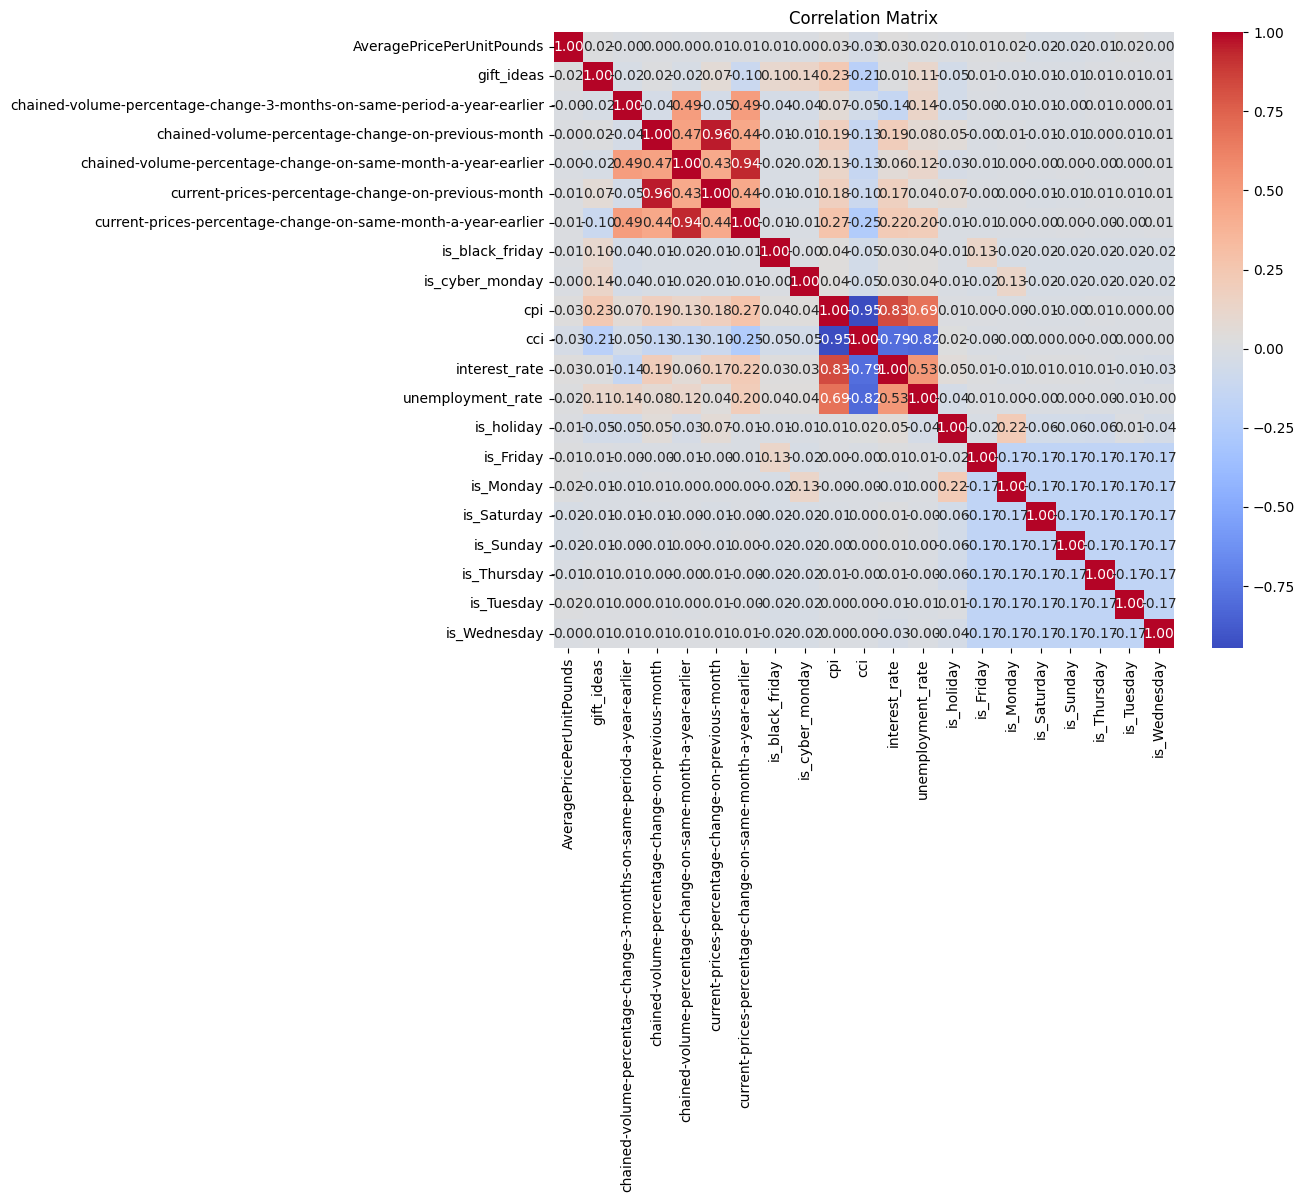

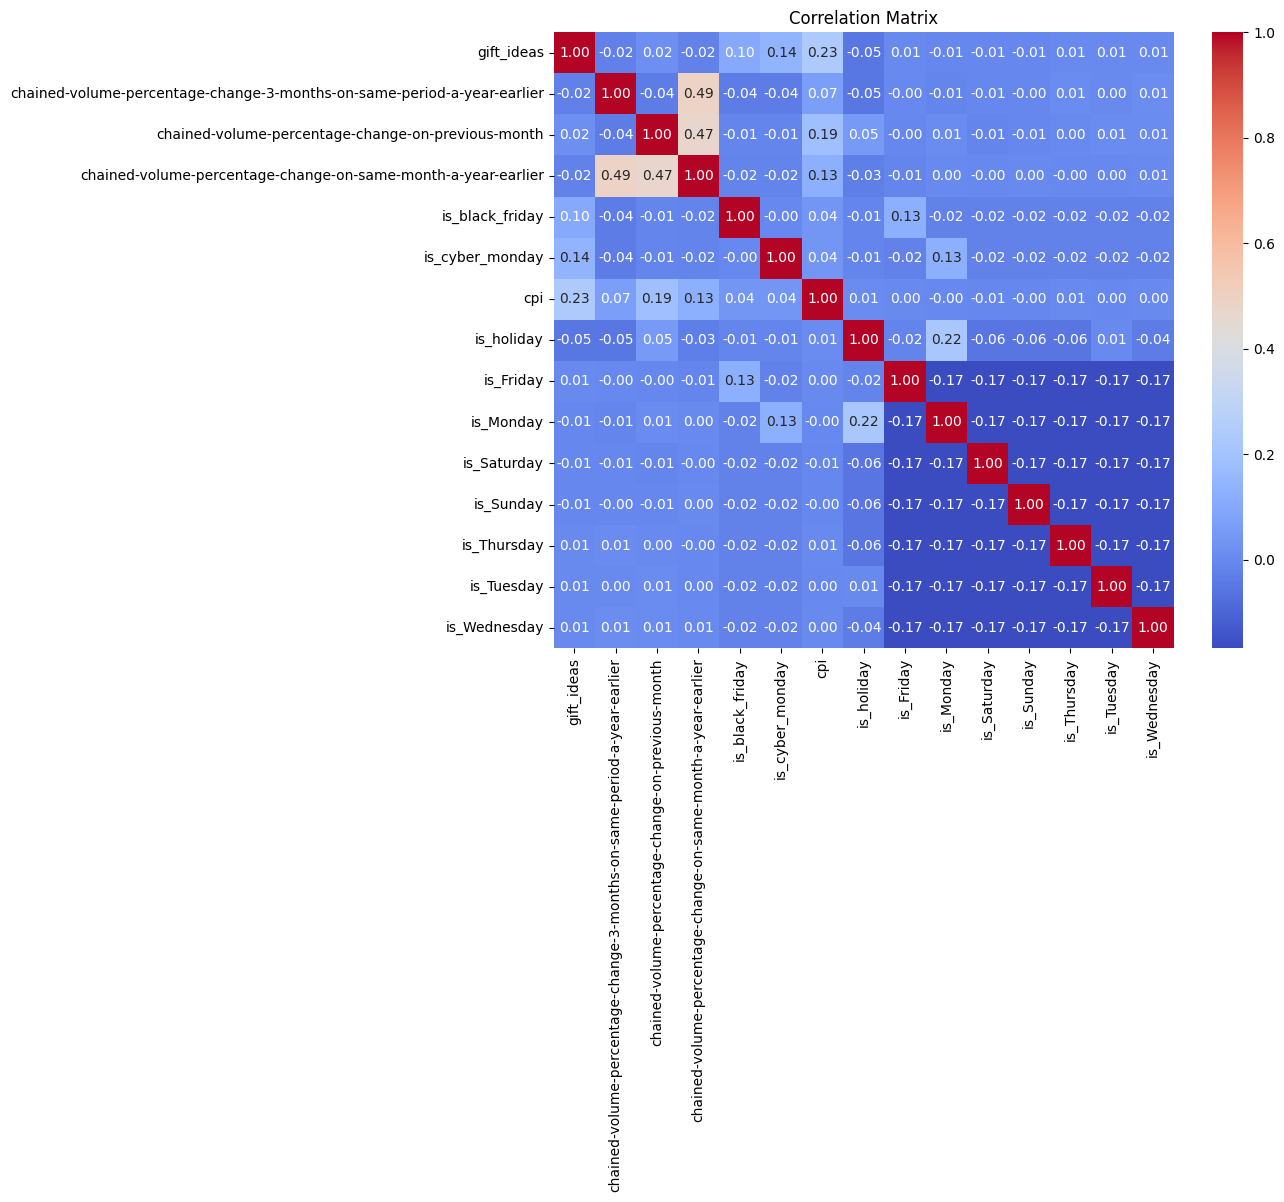

In [6]:
target = 'UnitsSold'
explanatory_vars = data.columns.tolist()
explanatory_vars.remove('Date')
explanatory_vars.remove('Description')
explanatory_vars.remove('RevenuePounds')
explanatory_vars.remove('UnitsSold')
explanatory_vars.remove('K-Means_Cluster')
explanatory_vars.remove('DBScan')
explanatory_vars.remove('HDBScan')
explanatory_vars.remove('Spectral-Cluster')
explanatory_vars

corr_matrix = data[explanatory_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# drop correlation > 0.8 from explanatory_vars
corr_threshold = 0.8
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) >= corr_threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

explanatory = explanatory.drop(columns=to_drop)
explanatory.drop('Date', axis=1, inplace=True)

corr_matrix = explanatory.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [7]:
def train_cluster(clustered_data, model_path='best_model.keras'):
    clustered_data = add_sequences(clustered_data)
    train_data, val_data, test_data = split_data(clustered_data, train_end_date="2010-12-31", val_end_date="2011-05-31")
    print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

    X_train, y_train = create_sequences(train_data)
    X_val, y_val = create_sequences(val_data)
    X_test, y_test = create_sequences(test_data)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=[sMAPE])

    checkpoint = ModelCheckpoint(
        filepath=model_path,
        monitor='val_s_mape',
        mode='min',
        save_best_only=True,
        verbose=0
    )

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint],
        verbose=0
    )

    # Load using the native format
    best_epoch = np.argmin(history.history['val_s_mape']) + 1
    best_model = tf.keras.models.load_model(model_path, custom_objects={'sMAPE': sMAPE})

    return best_model, history, best_epoch


In [ ]:
model = {}
history = {}
best_epochs = {}
cols = ['Date', 'Description', 'UnitsSold', 'AveragePricePerUnitPounds']
explanatory_vars = explanatory.columns.tolist()
cols.extend(explanatory_vars)

# print(cols)

for cluster in cluster_cols:
    print(f'Training {cluster}...')
    for i in tqdm(data[cluster].dropna().unique()):
        print(f"Cluster {i}")
        # print("Products are: ")
        # for product in data[data[cluster] == i]['Description'].unique():
            # print(product)
        clustered_data = data[data[cluster] == i][cols]
        model_instance, history_instance, best_epoch = train_cluster(clustered_data)
        model[(cluster, i)] = model_instance
        history[(cluster, i)] = history_instance
        best_epochs[(cluster, i)] = best_epoch

Training K-Means_Cluster...


  0%|          | 0/13 [00:00<?, ?it/s]

Cluster 1
Train: 4392, Val: 2172, Test: 2664


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
  8%|▊         | 1/13 [02:06<25:15, 126.32s/it]

Cluster 10
Train: 4026, Val: 1991, Test: 2442


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 15%|█▌        | 2/13 [03:40<19:41, 107.41s/it]

Cluster 5
Train: 4392, Val: 2172, Test: 2664


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 23%|██▎       | 3/13 [05:34<18:26, 110.63s/it]

Cluster 0
Train: 6222, Val: 3077, Test: 3774


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 31%|███       | 4/13 [07:58<18:34, 123.81s/it]

Cluster 2
Train: 3294, Val: 1629, Test: 1998


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
 38%|███▊      | 5/13 [09:27<14:47, 110.98s/it]

Cluster 7
Train: 5124, Val: 2534, Test: 3108


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def predict_cluster(models, clustered_data, seq_length=30, pred_length=1, additional_static_cols=None):
    """
    Predicts UnitsSold using trained LSTM models on the test set of a cluster.

    Args:
        models (tf.keras.Model): Trained LSTM model.
        clustered_data (pd.DataFrame): Cluster-specific DataFrame with sequences and features.
        seq_length (int): Number of historical days used as input sequence.
        pred_length (int): Number of steps ahead to predict.
        additional_static_cols (list, optional): Static feature column names to include in sequences.

    Returns:
        y_true (np.ndarray): Actual UnitsSold values from test data.
        y_pred (np.ndarray): Predicted UnitsSold values from the model.
        product_info (dict): Mapping of product descriptions to their test set rows.
    """
    # Format data with sequences
    clustered_data = add_sequences(clustered_data, seq_length, pred_length)

    # Split into train/val/test using fixed cutoff dates
    train_data, val_data, test_data = split_data(
        clustered_data,
        train_end_date="2010-12-31",
        val_end_date="2011-05-31"
    )

    # Map each product to its subset for potential analysis
    product_info = {
        product: test_data[test_data['Description'] == product]
        for product in test_data['Description'].unique()
    }

    # Build test input sequences
    if additional_static_cols:
        X_test, y_true = create_sequences(test_data, seq_length, additional_static_cols=additional_static_cols)
    else:
        X_test, y_true = create_sequences(test_data, seq_length)

    # Predict
    y_pred = models.predict(X_test, verbose=0)

    return y_true, y_pred, product_info


In [ ]:
def plot_training_history(history, title="Training History", best_epoch=None):
    sns.set(style="whitegrid", font_scale=1.1)

    hist_df = pd.DataFrame(history.history)
    hist_df['Epoch'] = range(1, len(hist_df) + 1)

    long_df = hist_df.melt(id_vars='Epoch', var_name='Metric', value_name='Value')
    long_df['Set'] = long_df['Metric'].apply(lambda x: 'Validation' if x.startswith('val_') else 'Training')
    long_df['Metric'] = long_df['Metric'].str.replace('val_', '')

    # Create plot grid
    g = sns.relplot(
        data=long_df,
        x='Epoch',
        y='Value',
        col='Metric',
        hue='Set',
        kind='line',
        facet_kws={'sharey': False, 'sharex': True},
        height=4,
        aspect=1.4,
        palette='muted'
    )

    g.set_titles(col_template="{col_name}", size=13)
    g.set_axis_labels("Epoch", "Metric Value")
    g.fig.suptitle(title, fontsize=18, fontweight='bold')
    g.tight_layout()
    g.fig.subplots_adjust(top=0.85)

    # Annotate best epoch if given
    if best_epoch is not None:
        for ax in g.axes.flat:
            ax.axvline(best_epoch, linestyle="--", color="gray", label=f"Best Epoch: {best_epoch}")
            ax.legend(loc='best')

    plt.show()

In [ ]:
def predict_segments(model, clustered_data, title):
    """
    Plots prediction error (y_pred - y_true) for each product in the test set.

    Args:
        model (tf.keras.Model): Trained LSTM model.
        clustered_data (pd.DataFrame): Full dataset for the cluster.
    """
    # Split data
    _, _, test_data = split_data(
        clustered_data,
        train_end_date="2010-12-31",
        val_end_date="2011-05-31"
    )

    # Set up plot
    plt.figure(figsize=(14, 6))
    sns.set(style="whitegrid", font_scale=1.1)

    for product in test_data['Description'].unique():
        product_data = test_data[test_data['Description'] == product]

        # Prepare date and sequences
        date_vector = product_data['Date'][30:]
        product_data = add_sequences(product_data)
        X_test, _ = create_sequences(product_data)

        # Make predictions and compute errors
        y_pred = model.predict(X_test, verbose=0).flatten()
        actual = product_data['UnitsSold'].values[-len(y_pred):]
        error = y_pred - actual

        # Plot error line
        sns.lineplot(x=date_vector, y=error, alpha=0.5, linewidth=1.2, label=product)

    # Final plot adjustments
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1.0)
    plt.ylim(-150, 150)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Prediction Error (y_pred - y_true)", fontsize=12)

    # Move legend outside the plot
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title="Product", fontsize=9)
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)  # Make room for the legend
    plt.show()

In [ ]:
def plot_predictions(y_true, y_pred, title="LSTM Forecast: True vs Predicted"):
    """
    Plots true vs predicted values of UnitsSold using seaborn.

    Args:
        y_true (array-like): Actual UnitsSold values.
        y_pred (array-like): Predicted UnitsSold values.
        title (str): Title of the plot.
    """
    sns.set(style="whitegrid", font_scale=1.1)

    # Flatten and convert to DataFrame
    df_plot = pd.DataFrame({
        'Time Step': range(len(y_true)),
        'True UnitsSold': y_true.flatten(),
        'Predicted UnitsSold': y_pred.flatten()
    })

    plt.figure(figsize=(14, 6))

    # Plot true and predicted lines
    sns.lineplot(data=df_plot, x='Time Step', y='True UnitsSold', label='True', alpha=0.6, linewidth=2)
    sns.lineplot(data=df_plot, x='Time Step', y='Predicted UnitsSold', label='Predicted', color='red', alpha=0.6, linewidth=2)

    # Format title and labels
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("UnitsSold", fontsize=12)

    # Move legend outside the plot
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10, title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)  # Space for legend
    plt.show()

In [ ]:
for i, j in model:
    print(i, j)
    y_true, y_pred, product_info = predict_cluster(model[(i, j)], data[data[i] == j][cols])
    predict_segments(model[(i, j)], data[data[i] == j][cols], title=f"Method {i}, Cluster {j}: Prediction Error for Each Product")
    plot_training_history(history[(i, j)], best_epoch=best_epochs[(i, j)], title=f"Method {i}, Cluster {j}: Training History")
    plot_predictions(y_true, y_pred, title=f"Method {i}, Cluster {j}: True vs Predicted UnitsSold")

In [ ]:
# smoothen y_true for plotting
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    # Flatten the array to 1-dimension before convolving
    y_smooth = np.convolve(y.flatten(), box, mode='same')
    return y_smooth

y_smooth = smooth(y_true, 5)
plot_predictions(y_true, y_pred, title="Cluster 0: True vs Predicted UnitsSold (Smoothed)")

In [ ]:
def plot_model_performances(model, product_info):
    for product in product_info.keys():
        print(model)

In [ ]:
plot_model_performances(model, product_info)